# Mély tanulási módszerek mellkas röntgen felvételek elemzésére #

A ChestX-ray14 15-féle címkével ellátott mellkas röntgen felvételeket tartalmazó adatbázis 63,328 férfi felvételét elemeztem konvolúciós neurális hálók segítségével. Először az egészséges felvételeken tanított mesterséges neurális hálóval próbáltam meg megbecsülni a páciensek biológiai életkorát. Ezt követően szintén egy több rétegből álló modellt tanítottam az egészséges felvételek felismerésére, majd ennek a modellnek az architektúráját felhasználva megkíséreltem a három leggyakrabban eloforduló betegség és az egészséges képek felismerését.

A felhasznált adatok, modell súlyok elérhetőek itt: https://drive.google.com/file/d/15fDJOnQS5YZaiKSOomSr0gb51w2etRSs/view?usp=sharing

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np

import os
import re
import sys

import pandas as pd

from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

from scipy import ndimage

from sklearn.metrics import accuracy_score, roc_auc_score


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, LSTM, SimpleRNN, GRU
from keras.layers import Convolution2D, MaxPooling2D, normalization
from keras.utils import np_utils
import keras.backend as K

#import xgboost as xgb
#import eto_utils as utils

import scipy

%matplotlib inline 

Using TensorFlow backend.


# Beteg nem beteg? #

In [3]:


x = np.load("x_osszes.txt.npy")
y = np.load("y_osszes.txt.npy")

In [107]:
y.shape

(63328, 15)

In [4]:
idx = np.random.permutation(len(x))

In [5]:
x_act = x.reshape((len(x),100,100,1))



x_train = x_act[idx[:45000]]
y_train = y[idx[:45000]]
x_val = x_act[idx[45000:50000]]
y_val = y[idx[45000:50000]]
x_test = x_act[idx[50000:]]
y_test= y[idx[50000:]]

In [6]:
def betege(uj, regi):
    for i in range(len(regi)):
        if regi[i,10] == 1:
            uj[i,0] = 1
            uj[i,1] = 0
        else:
            uj[i,0] = 0
            uj[i,1] = 1
    return uj
        

In [7]:
y_train1 = betege(np.zeros((len(y_train), 2)), y_train)
y_val1 = betege(np.zeros((len(y_val), 2)), y_val)
y_test1 = betege(np.zeros((len(y_test), 2)), y_test)



In [8]:
np.save("y_train1.npy", y_train1)
np.save("y_val1.npy", y_val1)
np.save("y_test1.npy", y_test1)

In [15]:
np.save("x_train.npy", x_train)
np.save("x_val.npy", x_val)
np.save("x_test.npy", x_test)

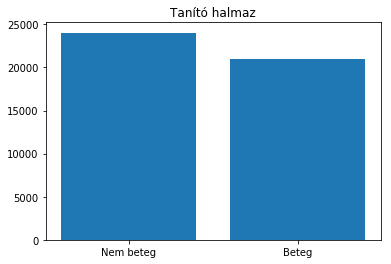

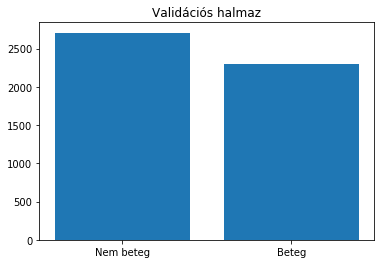

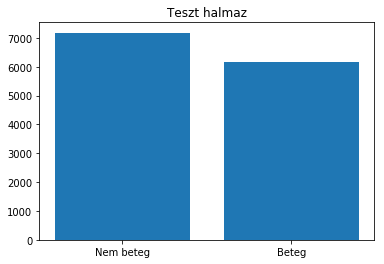

In [56]:
plt.bar(["Nem beteg", "Beteg"],[sum(y_train1[:,i]) for i in range(2)])
plt.title("Tanító halmaz")

plt.show()
plt.bar(["Nem beteg", "Beteg"],[sum(y_val1[:,i]) for i in range(2)])
plt.title("Validációs halmaz")

plt.show()
plt.bar(["Nem beteg", "Beteg"],[sum(y_test1[:,i]) for i in range(2)])
plt.title("Teszt halmaz")
plt.show()

In [11]:
from keras import regularizers
from keras.layers.normalization import BatchNormalization


In [16]:
model_b = Sequential()

model_b.add(Convolution2D(32,(5,5),strides=2,  input_shape=(100,100,1)))
model_b.add(Activation("relu"))

model_b.add(BatchNormalization())

model_b.add(Convolution2D(32,(3,3), kernel_regularizer=regularizers.l2(0.0001)))
model_b.add(Activation("relu"))
model_b.add(Convolution2D(32, (3,3),  kernel_regularizer=regularizers.l2(0.0001)))
model_b.add(Activation("relu"))
model_b.add(MaxPooling2D((3,3)))

##### Ezeddig nem volt benne ########

#model_b.add(Convolution2D(64, (3,3)))
#model_b.add(Activation("relu"))
#####################

model_b.add(BatchNormalization())

model_b.add(Convolution2D(64, (3,3), kernel_regularizer=regularizers.l2(0.0001)))
model_b.add(Activation("relu"))
model_b.add(Convolution2D(64, (3,3),  kernel_regularizer=regularizers.l2(0.0001)))
model_b.add(Activation("relu"))
model_b.add(MaxPooling2D())

########
#model_b.add(Convolution2D(128, (3,3), padding="same"))
#model_b.add(Activation("relu"))
#model_b.add(Dropout(0.5))

########
#model_b.add(MaxPooling2D((3,3)))
#model_b.add(Convolution2D(128, (3,3)))
#model_b.add(Activation("relu"))
#model_b.add(MaxPooling2D())
#model_b.add(Convolution2D(256, (3,3)))
#model_b.add(Activation("relu"))
#model_b.add(MaxPooling2D())


model_b.add(Flatten())

#######

#model_b.add(Dense(128))
#model_b.add(Activation('relu'))

#######

model_b.add(Dropout(0.5))
model_b.add(Dense(64))
model_b.add(Activation('relu'))

model_b.add(BatchNormalization())
model_b.add(Dense(2))
model_b.add(Activation('softmax'))


In [43]:
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 32)        832       
_________________________________________________________________
activation_7 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 44, 44, 32)        0         
__________

In [17]:

import keras_metrics as km
model_b.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["acc", km.precision(), km.recall()])

In [18]:
batchsize = 32

epochs=50


from keras.callbacks import ModelCheckpoint

history3 = model_b.fit(x_train, y_train1,batch_size=batchsize, epochs=epochs, validation_data = (x_val, y_val1), shuffle=True, callbacks = [ModelCheckpoint("weightsVeg3.{epoch:02d}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)]
)

## Ki hasthagezet layerekkel ##
#historyN weightsN modellekhez
#historyN2 weightsN2 modellekhez

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 459s 10ms/step - loss: 0.6946 - acc: 0.6050 - precision: 0.6169 - recall: 0.6868 - val_loss: 0.6473 - val_acc: 0.6536 - val_precision: 0.6618 - val_recall: 0.7366
Epoch 2/50
45000/45000 [==============================] - 455s 10ms/step - loss: 0.6429 - acc: 0.6546 - precision: 0.6633 - recall: 0.7173 - val_loss: 0.6416 - val_acc: 0.6536 - val_precision: 0.6312 - val_recall: 0.8666
Epoch 3/50
45000/45000 [==============================] - 457s 10ms/step - loss: 0.6319 - acc: 0.6640 - precision: 0.6727 - recall: 0.7221 - val_loss: 0.6394 - val_acc: 0.6510 - val_precision: 0.7412 - val_recall: 0.5460
Epoch 4/50
45000/45000 [==============================] - 464s 10ms/step - loss: 0.6243 - acc: 0.6719 - precision: 0.6814 - recall: 0.7243 - val_loss: 0.6955 - val_acc: 0.5612 - val_precision: 0.7892 - val_recall: 0.2586
Epoch 5/50
45000/45000 [==============================] - 449s 10ms

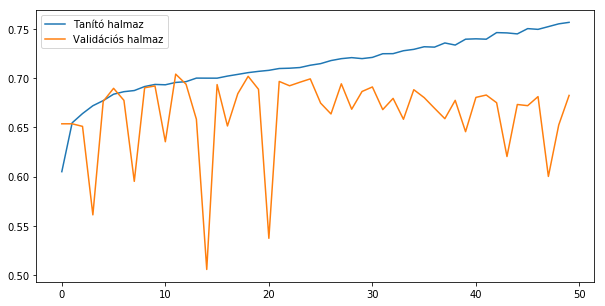

In [40]:
plt.figure(figsize=(10,5))

plt.plot(history3.history['acc'], label="Tanító halmaz")
plt.plot(history3.history['val_acc'], label="Validációs halmaz")
plt.legend()
plt.show()

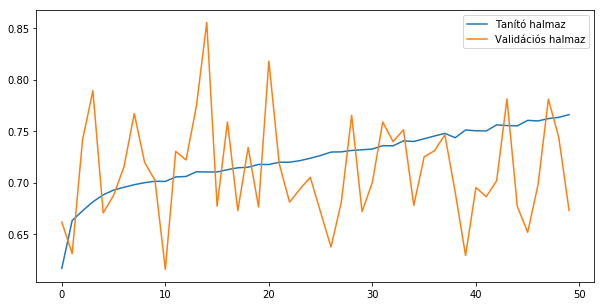

In [39]:
plt.figure(figsize=(10,5))

plt.plot(history3.history['precision'], label="Tanító halmaz")
plt.plot(history3.history['val_precision'], label="Validációs halmaz")
plt.legend()
plt.show()

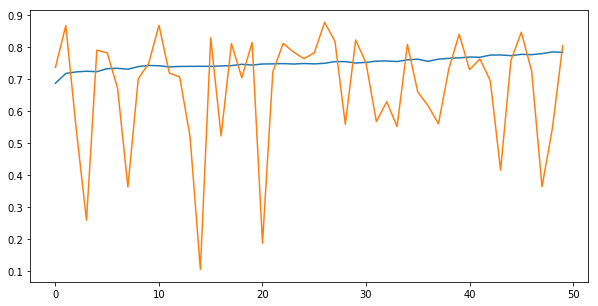

In [41]:
plt.figure(figsize=(10,5))


plt.plot(history3.history['recall'], label="Tanító halmaz")
plt.plot(history3.history['val_recall'],label="Validációs halmaz")

In [32]:
from keras.models import load_model, model_from_json
import keras_metrics as km

model = load_model("weightsVeg3.19.hdf5", compile=False)

**Roc-görbe és AUC a teszt adatokon**

In [33]:
y_P = model.predict(x_test)

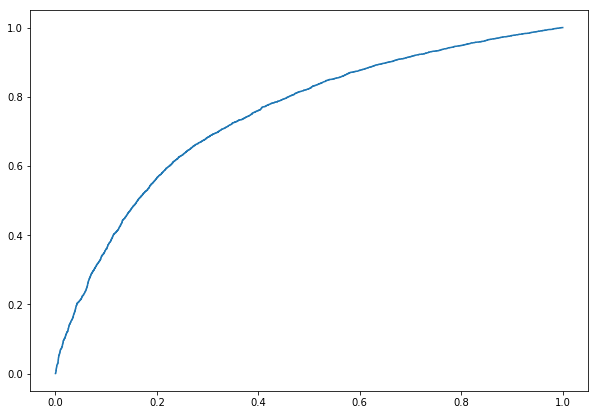

In [89]:
plt.figure(figsize=(10,7))


fpr, tpr, threshold = roc_curve(y_test1[:,0], list(y_P[:, 0]))
plt.plot(fpr, tpr)
plt.show()


In [34]:
roc_auc_score(y_test1, y_P)

0.7459521981121177

# Leggyakrabb 3 betegség osztályozása #

In [27]:


classes = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax']

<BarContainer object of 15 artists>

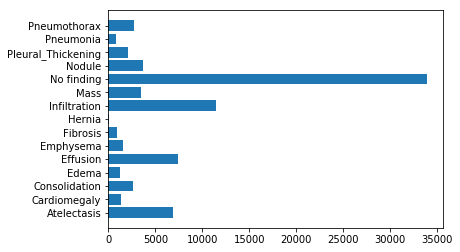

In [28]:
plt.barh(classes, [sum(y[:,i]) for i in range(15)])

In [3]:
x_osszes.shape

(63328, 100, 100)

In [57]:
#y_4= y_osszes[:, [0,4,8,10]]
classes4 = ['Légtelenség', 'Folyadékgyülem', 'Infiltrátum',
       'Nem beteg' ]

In [44]:
def top4(x,y):
    y_4= y[:, [0,4,8,10]]
    tor = []
    for i in range(len(y_4)):
        if np.all(y_4[i] == [0,0,0,0]):
            tor.append(i)
    x4 = np.delete(x, tor, 0)
    y4 = np.delete(y_4, tor, 0)
    return x4, y4

In [45]:
#x4 = np.delete(x_osszes, tor, 0)
#y4 = np.delete(y_4, tor, 0)

In [46]:
x4_train, y4_train = top4(x_train, y_train) 
x4_val, y4_val = top4(x_val,y_val)
x4_test, y4_test = top4(x_test,y_test)

In [47]:
np.save("x4_train.npy",x4_train )
np.save("y4_train.npy", y4_train)
np.save("x4_val.npy", x4_val)
np.save("y4_val.npy", y4_val)
np.save("x4_test.npy", x4_test)
np.save("y4_test.npy", y4_test)

In [48]:
x4_train.shape

(38596, 100, 100, 1)

In [49]:
x4_val.shape

(4294, 100, 100, 1)

In [50]:
x4_test.shape

(11384, 100, 100, 1)

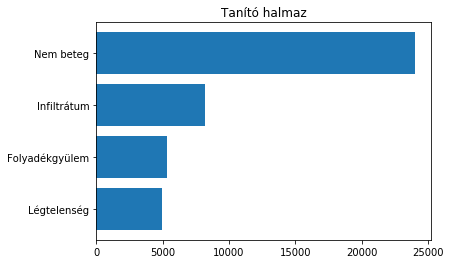

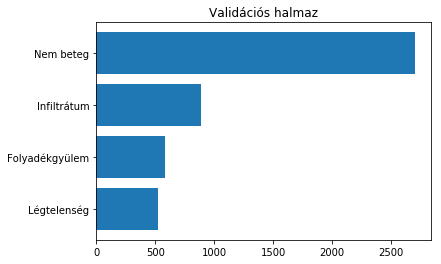

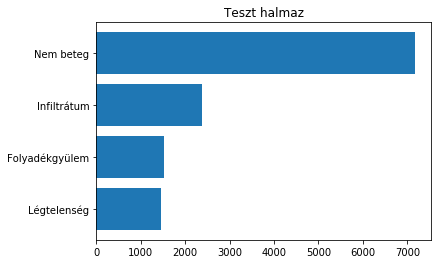

In [58]:
plt.barh(classes4,[sum(y4_train[:,i]) for i in range(4)])
plt.title("Tanító halmaz")

plt.show()
plt.barh(classes4,[sum(y4_val[:,i]) for i in range(4)])
plt.title("Validációs halmaz")

plt.show()
plt.barh(classes4,[sum(y4_test[:,i]) for i in range(4)])
plt.title("Teszt halmaz")
plt.show()

In [52]:
from keras.models import load_model
model_c = load_model("weightsVeg3.01.hdf5", compile=False)




In [53]:
model_c.layers[-2].units = 4
model_c = model_from_json(model_c.to_json())
model_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        832       
_________________________________________________________________
activation_8 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 44, 44, 32)        0         
__________

In [54]:
import keras_metrics as km
model_c.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["acc", km.precision(), km.recall()])

In [59]:

batchsize = 32

epochs=30


from keras.callbacks import ModelCheckpoint

historyC = model_c.fit(x4_train, y4_train,batch_size=batchsize, epochs=epochs, validation_data = (x4_val, y4_val), shuffle=True, callbacks = [ModelCheckpoint("weightsVeg6.{epoch:02d}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)]
)


Train on 38596 samples, validate on 4294 samples
Epoch 1/30
38596/38596 [==============================] - 419s 11ms/step - loss: 1.1851 - acc: 0.6161 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1892 - val_acc: 0.6304 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
38596/38596 [==============================] - 392s 10ms/step - loss: 1.1533 - acc: 0.6209 - precision: 0.6667 - recall: 4.0650e-04 - val_loss: 1.1715 - val_acc: 0.6241 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
38596/38596 [==============================] - 395s 10ms/step - loss: 1.1375 - acc: 0.6236 - precision: 1.0000 - recall: 4.0650e-04 - val_loss: 1.1904 - val_acc: 0.5957 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
38596/38596 [==============================] - 397s 10ms/step - loss: 1.1259 - acc: 0.6257 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.1451 - val_acc: 0.6223 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30


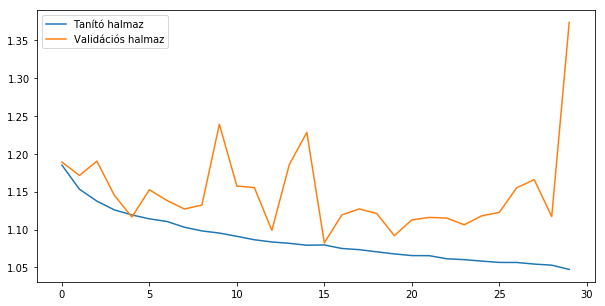

In [61]:
plt.figure(figsize=(10,5))

plt.plot(historyC.history['loss'], label="Tanító halmaz")
plt.plot(historyC.history['val_loss'], label="Validációs halmaz")
plt.legend()
plt.show()

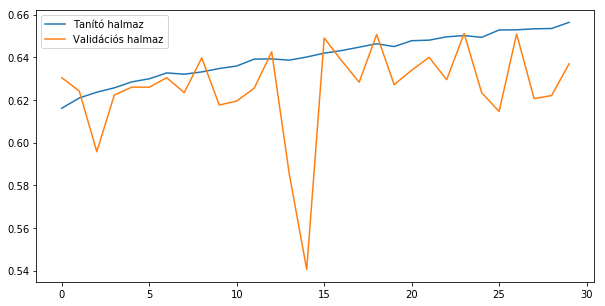

In [62]:
plt.figure(figsize=(10,5))

plt.plot(historyC.history['acc'], label="Tanító halmaz")
plt.plot(historyC.history['val_acc'], label="Validációs halmaz")
plt.legend()
plt.show()

**Roc-görbék és AUC értékek**

In [180]:
model_c = load_model("weightsVeg6.27.hdf5", compile=False)

In [181]:
y4P = model_c.predict(x4_test)

In [182]:
for i in range(4):
    print(roc_auc_score(y4_test[:,i], y4P[:, i]), classes4[i], sum(y4_test[:,i]) )
    


0.7468582205282585 Légtelenség 1465
0.8400847653404891 Folyadékgyülem 1516
0.6984489668672923 Infiltrátum 2370
0.7568275402187192 Nem beteg 7178


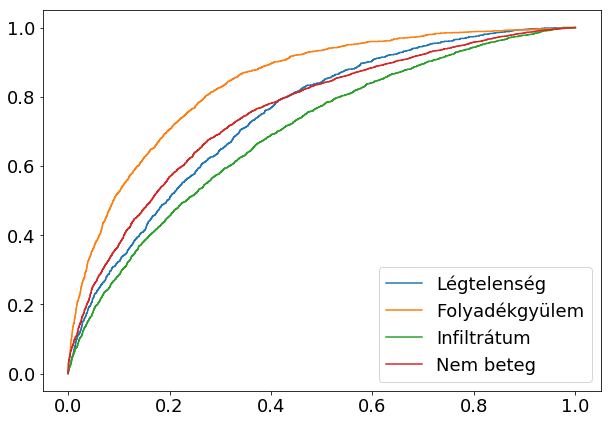

In [183]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(10,7))

for i in range(4):

    fpr, tpr, threshold = roc_curve(y4_test[:,i], list(y4P[:, i]))
    plt.plot(fpr, tpr, label=classes4[i])
plt.legend()
plt.show()


# Életkor Becslés #

In [90]:
x_age = np.load("100x100_feat.txt.npy")
y_age = np.load("100x100_label.txt.npy")

In [93]:
x_in = x_age.reshape((len(x_age),100,100,1))


In [111]:
x_test.shape

(13328, 100, 100, 1)

In [ ]:
tor = []

for i in range(len(x_test))

In [109]:
per_age = np.random.permutation(len(x_age))

In [110]:



xK_train = x_in[per_age[:25000]]
yK_train = y_age[per_age[:25000]]
xK_val = x_in[per_age[25000:30000]]
yK_val = y_age[per_age[25000:30000]]
xK_test = x_in[per_age[30000:]]
yK_test = y_age[per_age[30000:]]

In [114]:
np.save("xK_train.npy", xK_train)
np.save("yK_train.npy", yK_train)
np.save("xK_val.npy", xK_val)
np.save("yK_val.npy", yK_val)
np.save("xK_test.npy", xK_test)
np.save("yK_test.npy",yK_test )

In [115]:
model_kor = Sequential()
model_kor.add(Convolution2D(32, (5, 5), strides=2, input_shape=(100,100,1)))
model_kor.add(Activation('relu'))
model_kor.add(Convolution2D(32, (3, 3), padding='same'))
model_kor.add(Activation('relu'))
model_kor.add(MaxPooling2D(pool_size=(2, 2)))
model_kor.add(Dropout(0.25))

model_kor.add(Convolution2D(64, (3, 3), padding='same'))
model_kor.add(Activation('relu'))
model_kor.add(Convolution2D(64, (3, 3)))
model_kor.add(Activation('relu'))
model_kor.add(MaxPooling2D(pool_size=(2, 2)))
model_kor.add(Dropout(0.25))

model_kor.add(Flatten())
model_kor.add(Dense(512))
model_kor.add(Activation('relu'))
model_kor.add(Dropout(0.5))
model_kor.add(BatchNormalization())

model_kor.add(Dense(1))
model_kor.add(Activation('linear'))


In [116]:
model_kor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 48, 48, 32)        832       
_________________________________________________________________
activation_15 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 64)        18496     
__________

In [117]:
import keras.backend as K

def mean_chestpad(y_true, y_pred):
    return K.mean(y_true - y_pred)

In [118]:
model_kor.compile(loss='mse', optimizer='adam', metrics=["mse", "mae", mean_chestpad])

In [119]:

batchsize = 32

epochs=30


from keras.callbacks import ModelCheckpoint

historyKorVeg = model_kor.fit(xK_train, yK_train,batch_size=batchsize, epochs=epochs, validation_data = (xK_val, yK_val), shuffle=True, callbacks = [ModelCheckpoint("weightsVegK2.{epoch:02d}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)]
)

#historyKor weightsK1 modellekhez
#historyKor2 weightsK2 modellekhez
#historyKor3 weightsK3 modellekhez


Train on 25000 samples, validate on 5000 samples
Epoch 1/30
25000/25000 [==============================] - 198s 8ms/step - loss: 549.6965 - mean_squared_error: 549.6965 - mean_absolute_error: 17.5572 - mean_chestpad: 9.7299 - val_loss: 185.6737 - val_mean_squared_error: 185.6737 - val_mean_absolute_error: 11.2100 - val_mean_chestpad: 4.0221
Epoch 2/30
25000/25000 [==============================] - 194s 8ms/step - loss: 163.9051 - mean_squared_error: 163.9051 - mean_absolute_error: 10.2196 - mean_chestpad: -0.0261 - val_loss: 140.2597 - val_mean_squared_error: 140.2597 - val_mean_absolute_error: 9.3638 - val_mean_chestpad: -0.2622
Epoch 3/30
25000/25000 [==============================] - 192s 8ms/step - loss: 148.0566 - mean_squared_error: 148.0566 - mean_absolute_error: 9.6706 - mean_chestpad: 0.0169 - val_loss: 132.7880 - val_mean_squared_error: 132.7880 - val_mean_absolute_error: 9.0611 - val_mean_chestpad: -0.0891
Epoch 4/30
25000/25000 [==============================] - 193s 8ms/st

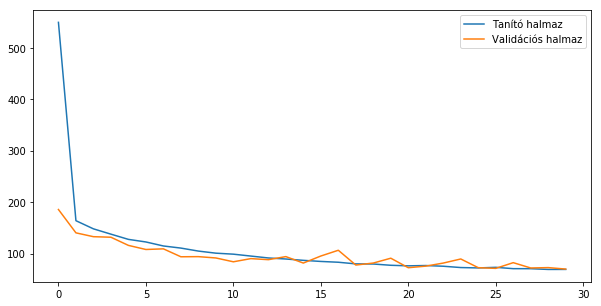

In [120]:
plt.figure(figsize=(10,5))

plt.plot(historyKorVeg.history['loss'], label="Tanító halmaz")
plt.plot(historyKorVeg.history['val_loss'], label="Validációs halmaz")
plt.legend()
plt.show()

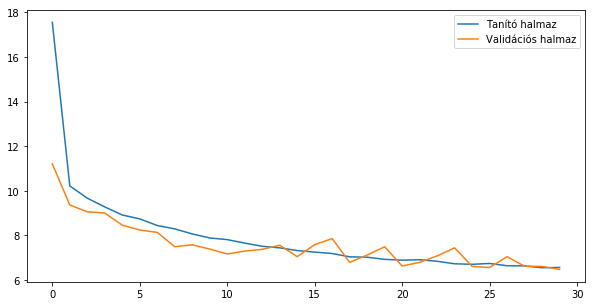

In [121]:
plt.figure(figsize=(10,5))

plt.plot(historyKorVeg.history['mean_absolute_error'], label="Tanító halmaz")
plt.plot(historyKorVeg.history['val_mean_absolute_error'], label="Validációs halmaz")
plt.legend()
plt.show()

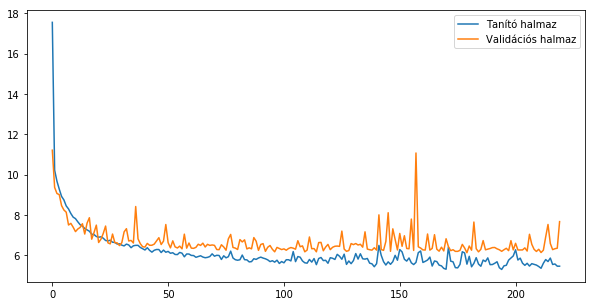

In [155]:
plt.figure(figsize=(10,5))

plt.plot(historyKorVeg.history['mean_absolute_error'] + historyKorVeg2.history['mean_absolute_error'] + historyKorVeg3.history["mean_absolute_error"]+ historyKorVeg4.history["mean_absolute_error"], label="Tanító halmaz")
plt.plot(historyKorVeg.history['val_mean_absolute_error'] + historyKorVeg2.history['val_mean_absolute_error'] + historyKorVeg3.history["val_mean_absolute_error"]+ historyKorVeg4.history["val_mean_absolute_error"], label="Validációs halmaz")
plt.legend()
plt.show()

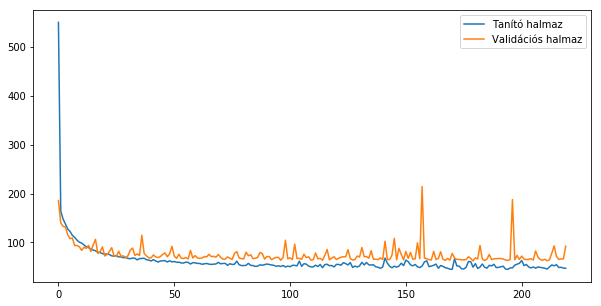

In [154]:
plt.figure(figsize=(10,5))

plt.plot(historyKorVeg.history['loss'] + historyKorVeg2.history['loss'] + historyKorVeg3.history["loss"] + historyKorVeg4.history["loss"], label="Tanító halmaz")
plt.plot(historyKorVeg.history['val_loss'] + historyKorVeg2.history['val_loss'] + historyKorVeg3.history["val_loss"] +historyKorVeg4.history["val_loss"], label="Validációs halmaz")
plt.legend()
plt.show()

In [122]:

batchsize = 32

epochs=40


from keras.callbacks import ModelCheckpoint

historyKorVeg2 = model_kor.fit(xK_train, yK_train,batch_size=batchsize, epochs=epochs, validation_data = (xK_val, yK_val), shuffle=True, callbacks = [ModelCheckpoint("weightsVegK5.{epoch:02d}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)]
)



Train on 25000 samples, validate on 5000 samples
Epoch 1/40
25000/25000 [==============================] - 194s 8ms/step - loss: 67.5938 - mean_squared_error: 67.5938 - mean_absolute_error: 6.4965 - mean_chestpad: 0.0066 - val_loss: 72.6522 - val_mean_squared_error: 72.6522 - val_mean_absolute_error: 6.6175 - val_mean_chestpad: -0.2448
Epoch 2/40
25000/25000 [==============================] - 194s 8ms/step - loss: 66.9016 - mean_squared_error: 66.9016 - mean_absolute_error: 6.4589 - mean_chestpad: -0.0016 - val_loss: 84.2898 - val_mean_squared_error: 84.2898 - val_mean_absolute_error: 7.1565 - val_mean_chestpad: 3.6343
Epoch 3/40
25000/25000 [==============================] - 194s 8ms/step - loss: 68.1832 - mean_squared_error: 68.1832 - mean_absolute_error: 6.5489 - mean_chestpad: 0.0099 - val_loss: 88.5995 - val_mean_squared_error: 88.5995 - val_mean_absolute_error: 7.3144 - val_mean_chestpad: -3.8557
Epoch 4/40
25000/25000 [==============================] - 195s 8ms/step - loss: 67.8

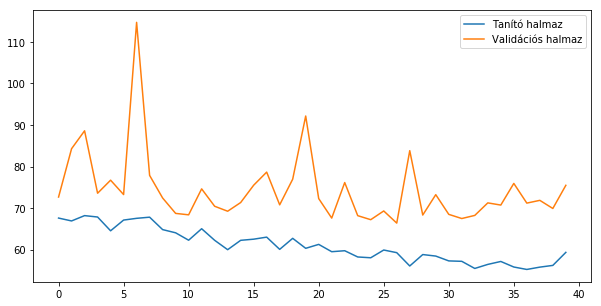

In [123]:
plt.figure(figsize=(10,5))

plt.plot(historyKorVeg2.history['loss'], label="Tanító halmaz")
plt.plot(historyKorVeg2.history['val_loss'], label="Validációs halmaz")
plt.legend()
plt.show()

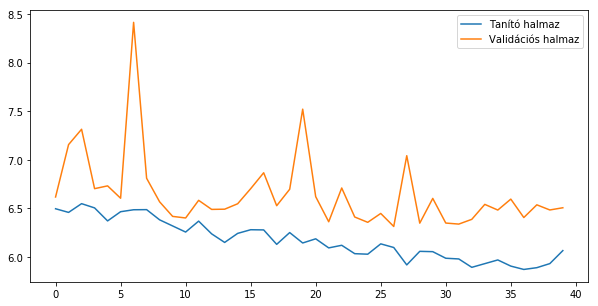

In [124]:
plt.figure(figsize=(10,5))

plt.plot(historyKorVeg2.history['mean_absolute_error'], label="Tanító halmaz")
plt.plot(historyKorVeg2.history['val_mean_absolute_error'], label="Validációs halmaz")
plt.legend()
plt.show()

In [145]:
model_kor = load_model("weightsVegK5.40.hdf5", compile=False)

In [146]:
model_kor.compile(loss='mse', optimizer='adam', metrics=["mse", "mae", mean_chestpad])

In [147]:
batchsize = 32

epochs=50


from keras.callbacks import ModelCheckpoint

historyKorVeg3 = model_kor.fit(xK_train, yK_train,batch_size=batchsize, epochs=epochs, validation_data = (xK_val, yK_val), shuffle=True, callbacks = [ModelCheckpoint("weightsVegK6a.{epoch:02d}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)]
)

Train on 25000 samples, validate on 5000 samples
Epoch 1/50
25000/25000 [==============================] - 197s 8ms/step - loss: 56.5131 - mean_squared_error: 56.5131 - mean_absolute_error: 5.9485 - mean_chestpad: 0.0059 - val_loss: 69.8504 - val_mean_squared_error: 69.8504 - val_mean_absolute_error: 6.4869 - val_mean_chestpad: -0.7997
Epoch 2/50
25000/25000 [==============================] - 191s 8ms/step - loss: 57.1309 - mean_squared_error: 57.1309 - mean_absolute_error: 5.9926 - mean_chestpad: -0.0026 - val_loss: 66.0115 - val_mean_squared_error: 66.0115 - val_mean_absolute_error: 6.2794 - val_mean_chestpad: 0.2920
Epoch 3/50
25000/25000 [==============================] - 191s 8ms/step - loss: 57.3339 - mean_squared_error: 57.3339 - mean_absolute_error: 5.9842 - mean_chestpad: 0.0159 - val_loss: 66.0519 - val_mean_squared_error: 66.0519 - val_mean_absolute_error: 6.2731 - val_mean_chestpad: -0.2796
Epoch 4/50
25000/25000 [==============================] - 191s 8ms/step - loss: 53.3

In [151]:
batchsize = 32

epochs=100


from keras.callbacks import ModelCheckpoint

historyKorVeg4 = model_kor.fit(xK_train, yK_train,batch_size=batchsize, epochs=epochs, validation_data = (xK_val, yK_val), shuffle=True, callbacks = [ModelCheckpoint("weightsVegK7a.{epoch:02d}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)]
)

Train on 25000 samples, validate on 5000 samples
Epoch 1/100
25000/25000 [==============================] - 194s 8ms/step - loss: 55.2934 - mean_squared_error: 55.2934 - mean_absolute_error: 5.8735 - mean_chestpad: 0.0170 - val_loss: 65.2632 - val_mean_squared_error: 65.2632 - val_mean_absolute_error: 6.2731 - val_mean_chestpad: -0.1390
Epoch 2/100
25000/25000 [==============================] - 193s 8ms/step - loss: 55.1245 - mean_squared_error: 55.1245 - mean_absolute_error: 5.8463 - mean_chestpad: -0.0025 - val_loss: 67.9583 - val_mean_squared_error: 67.9583 - val_mean_absolute_error: 6.3905 - val_mean_chestpad: 1.0494
Epoch 3/100
25000/25000 [==============================] - 193s 8ms/step - loss: 53.6552 - mean_squared_error: 53.6552 - mean_absolute_error: 5.7865 - mean_chestpad: -0.0043 - val_loss: 69.9151 - val_mean_squared_error: 69.9151 - val_mean_absolute_error: 6.4418 - val_mean_chestpad: 1.4801
Epoch 4/100
25000/25000 [==============================] - 195s 8ms/step - loss: 

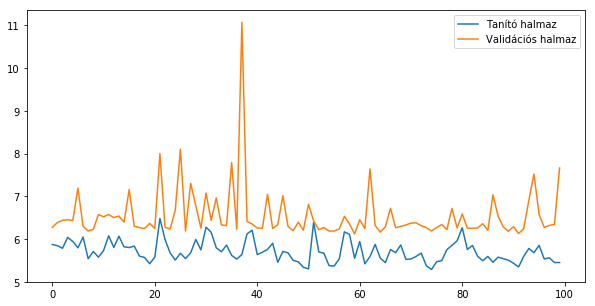

In [152]:
plt.figure(figsize=(10,5))

plt.plot(historyKorVeg4.history['mean_absolute_error'], label="Tanító halmaz")
plt.plot(historyKorVeg4.history['val_mean_absolute_error'], label="Validációs halmaz")
plt.legend()
plt.show()

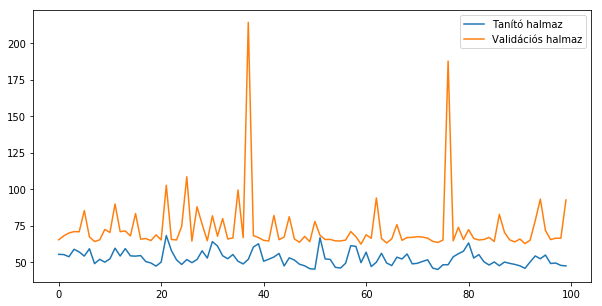

In [153]:
plt.figure(figsize=(10,5))

plt.plot(historyKorVeg4.history['loss'], label="Tanító halmaz")
plt.plot(historyKorVeg4.history['val_loss'], label="Validációs halmaz")
plt.legend()
plt.show()

In [91]:
import keras.backend as K

def mean_chestpad(y_true, y_pred):
    return K.mean(y_pred - y_true)

In [156]:
model_kor = load_model("weightsVegK7a.60.hdf5", compile=False)

In [157]:
yKP = model_kor.predict(xK_test)

**Átlagos eltérés a teszt adaton**

In [158]:
sum( list(yKP[:,0] - yK_test))/len(yK_test)

-0.1260908529147186

**Átlagos abszolút eltérés a teszt adaton**

In [159]:
sum( np.absolute(yKP[:,0] - yK_test))/len(yK_test)

5.943613840440198

### Beteg adatokon kimérés ###

In [160]:
beteg_adat_male = pd.read_csv("beteg_adat_male.csv")
kepek = np.load("kepek.txt.npy")

In [161]:
beteg_adat_male["pred_age"] = model_kor.predict(kepek.reshape(len(kepek),100,100,1))

In [162]:
beteg_adat_male["elter"] = beteg_adat_male["pred_age"] - beteg_adat_male["Patient Age"]

In [111]:
beteg_adat_male[:20]

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image,pred_age,elter
0,0,00000001_000.png,['Cardiomegaly'],0,1,58,M,PA,2682,2749,0.143,0.143,NaN,0,60.272320,2.272320
1,1,00000001_001.png,"['Cardiomegaly', 'Emphysema']",1,1,58,M,PA,2894,2729,0.143,0.143,NaN,1,58.521717,0.521717
2,2,00000001_002.png,"['Cardiomegaly', 'Effusion']",2,1,58,M,PA,2500,2048,0.168,0.168,NaN,2,72.530205,14.530205
3,12,00000004_000.png,"['Mass', 'Nodule']",0,4,82,M,AP,2500,2048,0.168,0.168,NaN,3,52.874477,-29.125523
4,26,00000009_000.png,['Emphysema'],0,9,73,M,PA,2992,2991,0.143,0.143,NaN,4,77.493385,4.493385
5,28,00000011_000.png,['Effusion'],0,11,75,M,PA,2638,2449,0.143,0.143,NaN,5,62.605564,-12.394436
6,33,00000011_005.png,['Infiltration'],5,11,75,M,AP,2500,2048,0.168,0.168,NaN,6,74.616463,-0.383537
7,34,00000011_006.png,['Atelectasis'],6,11,75,M,PA,2992,2991,0.143,0.143,NaN,7,69.410637,-5.589363
8,35,00000011_007.png,['Infiltration'],7,11,75,M,PA,2782,2753,0.143,0.143,NaN,8,74.489388,-0.510612
9,37,00000012_000.png,"['Effusion', 'Mass']",0,12,76,M,PA,2992,2991,0.143,0.143,NaN,9,82.105141,6.105141


In [163]:
import ast
for i in range(len(beteg_adat_male)):
    
    beteg_adat_male["Finding Labels"].values[i] = ast.literal_eval(beteg_adat_male["Finding Labels"].values[i])

In [164]:
betegseg_elteres = {}

for i in range(len(beteg_adat_male)):
    #beteg_adat_male["Finding Labels"].values[i] = beteg_adat_male["Finding Labels"].values[i].split("|")
    for betegseg in beteg_adat_male["Finding Labels"].values[i]:
        if betegseg in betegseg_elteres:
            betegseg_elteres[betegseg].append(beteg_adat_male["elter"].values[i])
        else:
            betegseg_elteres[betegseg] = [ beteg_adat_male["elter"].values[i] ]

In [165]:
betegseg = list(betegseg_elteres.keys())

mean_pad = []

darab = []
osszeg = []

for l in range(len(betegseg)):
    elteresek = betegseg_elteres[betegseg[l]]
    mean_pad.append(sum(elteresek)/len(elteresek))
    osszeg.append(sum(elteresek))
    darab.append(len(elteresek))

In [171]:
betegseg

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Mass',
 'Nodule',
 'Infiltration',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Consolidation',
 'Edema',
 'Hernia',
 'No Findings']

In [166]:
table = pd.DataFrame(mean_pad, betegseg)
#table["Összeg"] = osszeg
table["Darab"] = darab
table

,0,Darab
Cardiomegaly,0.227194,1307
Emphysema,0.325070,1610
Effusion,0.451097,7434
Mass,0.946188,3526
Nodule,0.132246,3685
Infiltration,0.404116,11425
Atelectasis,0.413392,6905
Pneumothorax,1.827801,2717
Pleural_Thickening,0.077968,2041
Pneumonia,0.995365,837


In [167]:
eg_hist = yKP[:,0] - np.array(yK_test)

In [168]:
betegseg_elteres["No Findings"] = eg_hist

In [172]:
betegseg = list(betegseg_elteres.keys())

In [173]:
betegseg

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Mass',
 'Nodule',
 'Infiltration',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Consolidation',
 'Edema',
 'Hernia',
 'No Findings']

In [174]:
magyar = [ "Szívnagyobbodás", "Tüdőtágulat", "Folyadékgyülem", "Csomó", "Góc", "Infiltrátum", "Légtelenség", "Légmell", "Pleura vastagodás", "Tüdőgyulladás", "Hegesedés", "Konszolidátum", "Ödéma", "Sérv", "Nem beteg"  ]

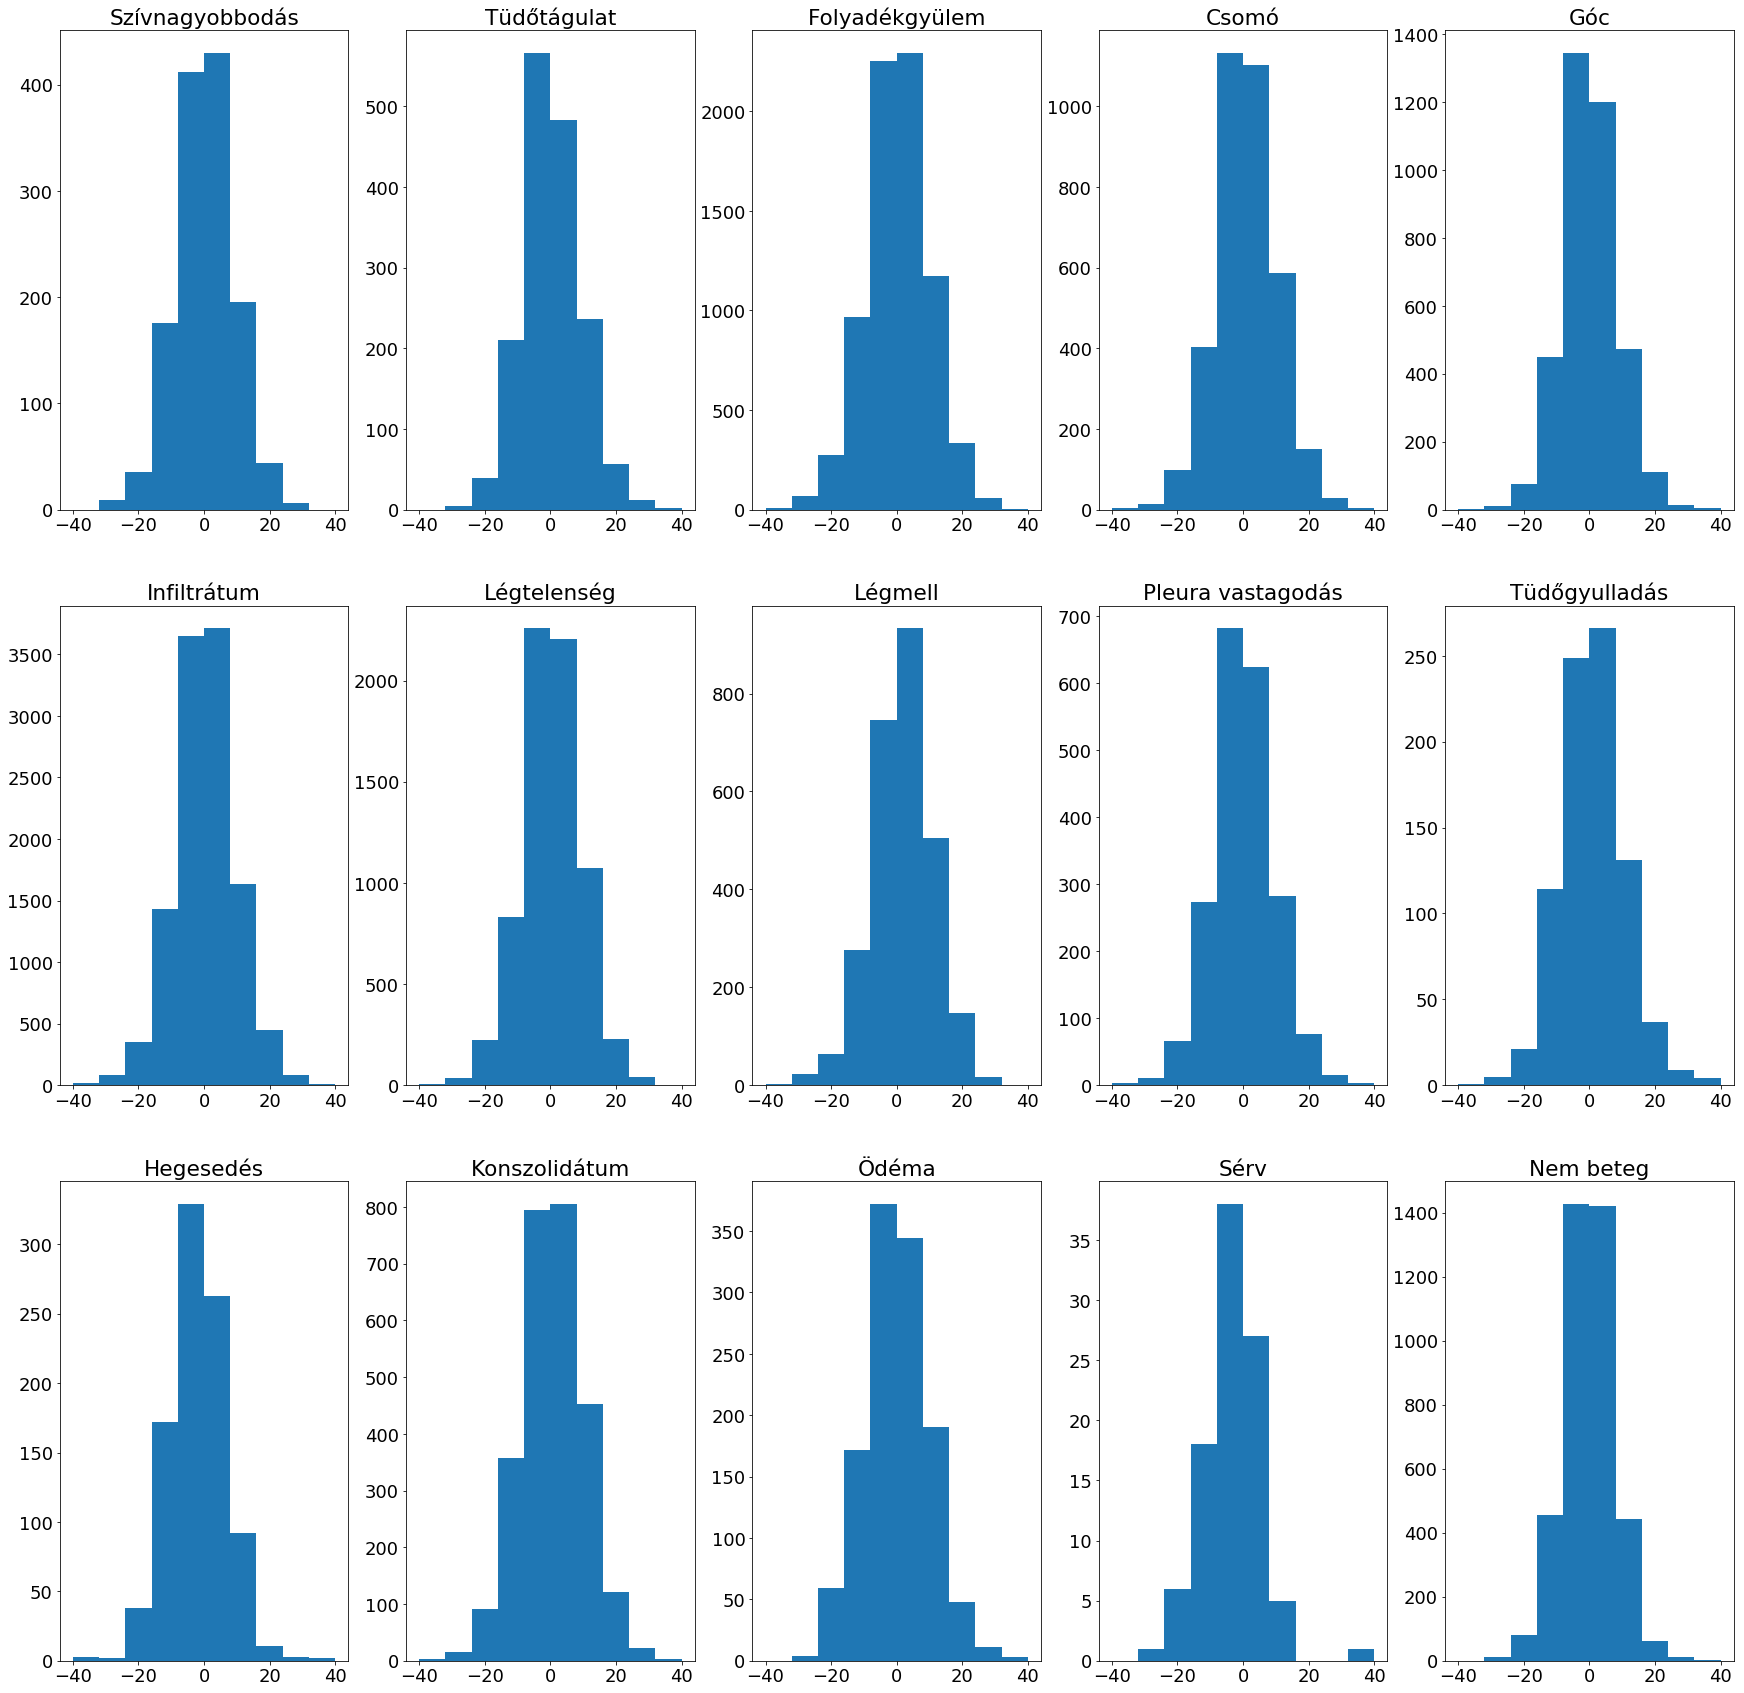

In [179]:
fig=plt.figure(figsize=(30, 30))

plt.rcParams.update({'font.size': 18})

for l in range(len(betegseg)):
    plt.subplot(3, 5, l+1)
    plt.hist(betegseg_elteres[betegseg[l]], range=(-40,40))
    plt.title(magyar[l])

plt.show()